# Tanzanian Water Wells

### Importing Libraries

In [1]:
# import all necessary libraries for project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus
import itertools

import sklearn.datasets as datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, confusion_matrix   
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## Exploratory Analysis

In [32]:
# import training set values as our explanatory variables
X = pd.read_csv('data/training_set_values.csv', index_col='id')

In [33]:
X.shape

(59400, 39)

In [34]:
# import status group as our dependent variable
y = pd.read_csv('data/status_group.csv', index_col='id')

In [35]:
# # a quick look into what our dependent variable looks like and if it is binary/multiclass
# checking for class imbalance here. It seems that functional needs repair is our minority, and functional is our majority.
# there is some class imbalance here.
y.value_counts()

status_group           
functional                 32259
non functional             22824
functional needs repair     4317
dtype: int64

In [36]:
# creating a dataframe with both our X and y joined by the 'id'
df = pd.concat([X, y], axis=1)

In [37]:
# a quick look at all variables within X (our explantory variables)
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [38]:
# a quick look at our X variables, showing their descriptive statistics. We can tell here that we are going to need to
# change construction year as it haas a mean of 1300. We caan also tell that region_code and distric_code are numbers,
# but they may be better off as categories. This is a great way to what our numerical independet variables are doing.
X.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [39]:
# checking to see whaat variables have NA values. Many variables have NA values that we will have to deal with.
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [40]:
# calculate baseline for model. Baseline is roughly 54%. We want our model to beat that number.
baseline = 32259/(32259+22824+4317)
baseline

0.543080808080808

In [41]:
X.population[X.population ==0].value_counts()

0    21381
Name: population, dtype: int64

In [42]:
# looking to see if the quantity of the water can give us information regarding our status group
df.groupby(['quantity_group', 'status_group'])['status_group'].count().unstack()

status_group,functional,functional needs repair,non functional
quantity_group,,,
dry,157,37,6052
enough,21648,2400,9138
insufficient,7916,1450,5763
seasonal,2325,416,1309
unknown,213,14,562


<AxesSubplot:>

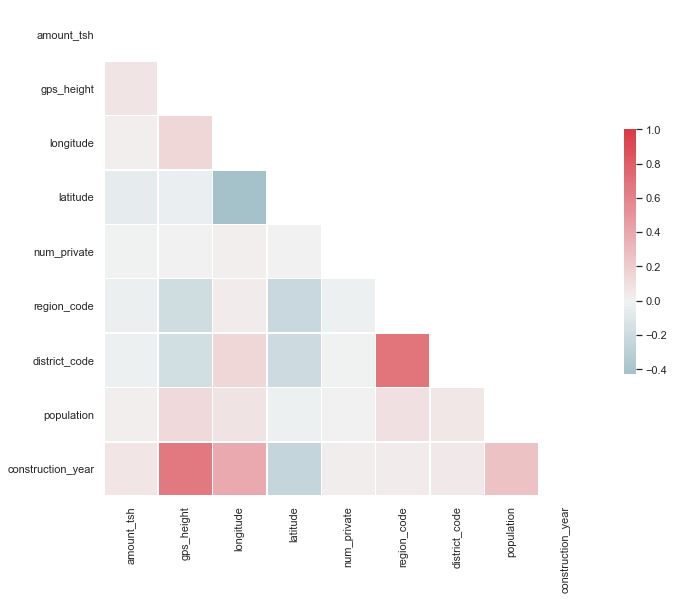

In [43]:
sns.set(style="white")
# Compute the correlation matrix
corr = X.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

##### This is a great way to see if there is any multicollinearity between our discrete independent variabls. As we see here region_code and district_code are highly correlated (as we might expect) so if we choose to use them in our model, we would like to only use one. 

## Data Cleaning

In [44]:
sns.set_style('darkgrid')
sns.set_context('poster')

<ipython-input-45-5661e12c0c0c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['functional', 'non functional', 'functional needs repair'], rotation=45);


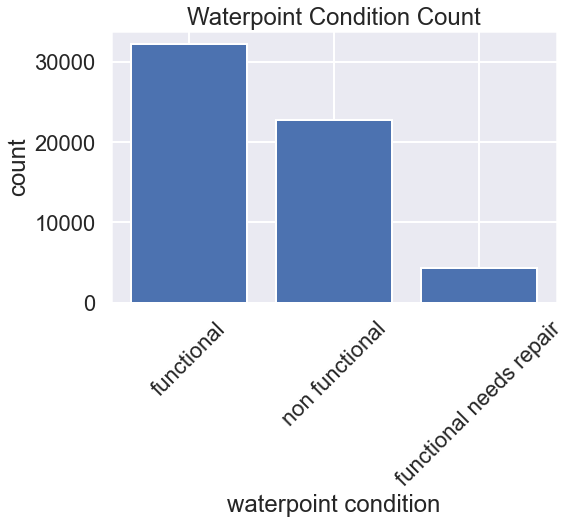

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(['functional', 'non functional', 'functional needs repair'], y.value_counts(), color = 'b')
ax.set_title('Waterpoint Condition Count')
ax.set_xlabel('waterpoint condition')
ax.set_ylabel('count')
ax.set_xticklabels(['functional', 'non functional', 'functional needs repair'], rotation=45);

In [46]:
# Changing our dependent variable from multiclass to binary
y.status_group = y.status_group.map({'functional': 'functional', 'functional needs repair': 'non functional', 'non functional': 'non functional'})

<ipython-input-47-8ec07ac16428>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['functional', 'non functional'], rotation=45);


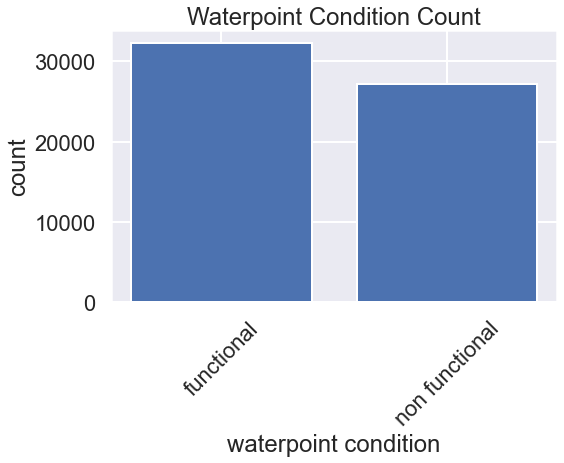

In [47]:
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(['functional', 'non functional'], y.value_counts(), color = 'b')
ax.set_title('Waterpoint Condition Count')
ax.set_xlabel('waterpoint condition')
ax.set_ylabel('count')
ax.set_xticklabels(['functional', 'non functional'], rotation=45);

#### Map target variable to 0 and 1

In [48]:
y.status_group = y.status_group.map({'functional': 0, 'non functional': 1})
y.status_group

id
69572    0
8776     0
34310    0
67743    1
19728    0
        ..
60739    0
27263    0
37057    0
31282    0
26348    0
Name: status_group, Length: 59400, dtype: int64

<ipython-input-49-f02fb909d448>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '1'], rotation=0);


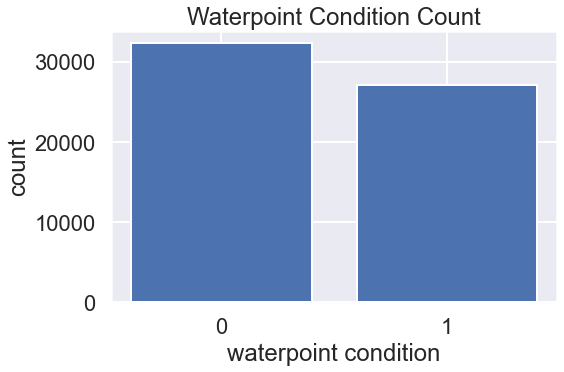

In [49]:
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(['0', '1'], y.value_counts(), color = 'b')
ax.set_title('Waterpoint Condition Count')
ax.set_xlabel('waterpoint condition')
ax.set_ylabel('count')
ax.set_xticklabels(['0', '1'], rotation=0);

In [50]:
# If there is no value for public meeting, we replaced that value with false indicating there is no public meeting that took place
X.public_meeting.fillna(value = False, inplace = True)

In [51]:
# If there is no value for permit, we replaced NA with false indicating that there is no permit for that observation
X.permit.fillna(value = False, inplace = True)

In [52]:
X.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

#### Replace construction_year==0

In [53]:
# Created a variable for the mean of construction year in a given region
year_region = X[X.construction_year != 0].groupby('region').construction_year.mean().round()
# Created a variable for the mean of construction year throughout observations if construction year does not = 0
year_mean = X[X.construction_year != 0].construction_year.mean()
# Any place where construction year = 0, we replaced with na values
X.construction_year = np.where(X.construction_year==0, np.nan, X.construction_year)
# We filled the construction year values with the mean of the construction year in that given region
X.construction_year.fillna(df.region.map(year_region), inplace=True)
# If that give region does not have a mean for construction year, we replaced the construction year value with the overall data sets mean for construction year
X.construction_year.fillna(year_mean, inplace=True)  # set remaining NaN to 1997

#### Change construction_year for 10 rows where construction_year>date_recorded¶

In [55]:
X.date_recorded = pd.to_datetime(X.date_recorded)
X.date_recorded.dt.year

id
69572    2011
8776     2013
34310    2013
67743    2013
19728    2011
         ... 
60739    2013
27263    2011
37057    2011
31282    2011
26348    2011
Name: date_recorded, Length: 59400, dtype: int64

In [56]:
X[X.construction_year > X.date_recorded.dt.year].index

Int64Index([14428, 20198, 55069, 48759, 20534, 53086, 9195, 5971, 15921, 1251], dtype='int64', name='id')

In [57]:
# indexes [14428, 20198, 55069, 48759, 20534, 53086, 9195, 5971, 15921, 1251]
X.loc[14428, 'construction_year'] = 2002
X.loc[20198, 'construction_year'] = 2004
X.loc[55069, 'construction_year'] = 2004
X.loc[48759, 'construction_year'] = 2004
X.loc[20534, 'construction_year'] = 2004
X.loc[53086, 'construction_year'] = 2004
X.loc[9195, 'construction_year'] = 2004
X.loc[5971, 'construction_year'] = 2004
X.loc[15921, 'construction_year'] = 2004
X.loc[1251, 'construction_year'] = 2004

#### Add column age = date_recorded.year - construction_year


In [59]:
X['age'] = X['date_recorded'].dt.year - X['construction_year']
X['age'].min()

0.0

#### Reformat date_recorded as 2021-date_recorded

In [60]:
dates = pd.to_datetime(X.date_recorded)
year2021 = pd.to_datetime('2021-01-01')
years = [i.days/365 for i in (year2021 - dates)]
X.date_recorded = years

#### For column installer: if value_counts()<200, add to category "other"

In [63]:
threshold = 200
cols = ['installer']

for col in cols:
    valued_dict = dict(X[col].value_counts())
    safe_values = list(key for key, value in valued_dict.items() if value >= threshold)
    X.loc[:, col] = X.loc[:, col].map(lambda y: 'other' if y not in safe_values else y)

X.installer.unique()

array(['other', 'World vision', 'UNICEF', 'DWE', 'DANIDA', 'WEDECO',
       'District council', 'WU', 'Central government', 'Commu',
       'World Vision', 'LGA', 'Government', 'KKKT', 'RWE', 'SEMA',
       'HESAWA', 'ACRA', 'Community', 'Sengerema Water Department', 'CES',
       'Hesawa', 'TASAF', '0', 'Idara ya maji', 'DANID', 'Dmdd', 'TCRS',
       'AMREF', 'Gove', 'TWESA', 'FinW', 'OXFAM', 'District Council',
       'NORAD', 'Gover', 'DW', 'DH', 'Kiliwater', 'Da'], dtype=object)

#### Concatenate X and y into df (again)

In [67]:
df = pd.concat([X, y], axis=1)

In [68]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

## Create visualizations

In [69]:
df.groupby(['extraction_type', 'status_group'])['status_group'].count().unstack()

status_group,0,1
extraction_type,,
afridev,1200.0,570.0
cemo,45.0,45.0
climax,8.0,24.0
gravity,16048.0,10732.0
india mark ii,1448.0,952.0
india mark iii,44.0,54.0
ksb,703.0,712.0
mono,1082.0,1783.0
nira/tanira,5421.0,2733.0


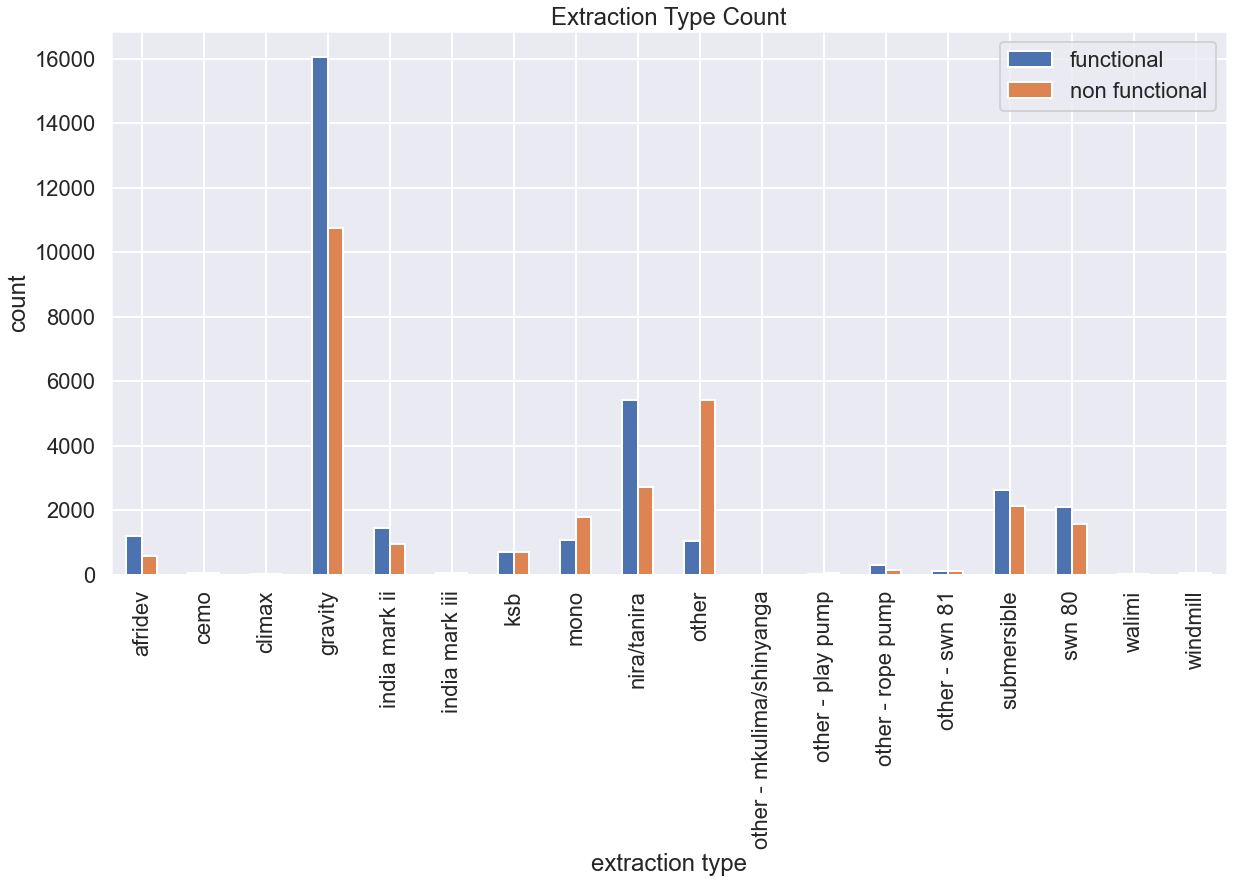

In [70]:
# extraction_type has 0 NaN
fig, ax = plt.subplots(figsize=(20,10))
df.groupby(['extraction_type', 'status_group'])['status_group'].count().unstack().plot(kind = 'bar', ax=ax)
ax.set_title('Extraction Type Count')
ax.set_xlabel('extraction type')
ax.set_ylabel('count')
ax.legend(labels=['functional', 'non functional'])
plt.xticks(rotation=90)
plt.show();

In [71]:
df.groupby(['waterpoint_type', 'status_group'])['status_group'].count().unstack()

status_group,0,1
waterpoint_type,,
cattle trough,84,32
communal standpipe,17726,10796
communal standpipe multiple,2235,3868
dam,6,1
hand pump,10805,6683
improved spring,563,221
other,840,5540


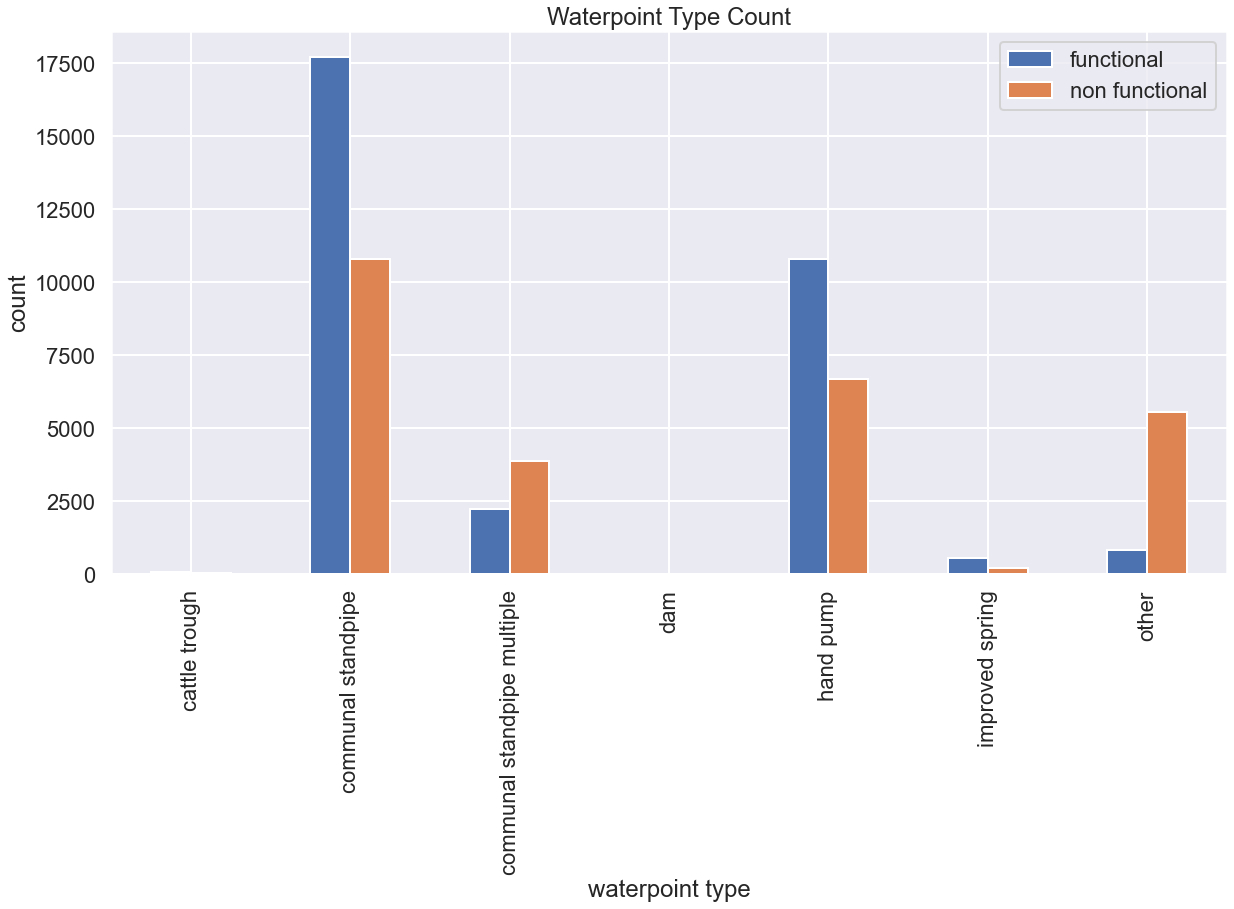

In [72]:
# waterpoint_type has 0 NaN
fig, ax = plt.subplots(figsize=(20,10))
df.groupby(['waterpoint_type', 'status_group'])['status_group'].count().unstack().plot(kind = 'bar', ax=ax)
ax.set_title('Waterpoint Type Count')
ax.set_xlabel('waterpoint type')
ax.set_ylabel('count')
ax.legend(labels=['functional', 'non functional'])
plt.xticks(rotation=90)
plt.show();

In [73]:
df.groupby(['quantity_group', 'status_group'])['status_group'].count().unstack()

status_group,0,1
quantity_group,,
dry,157,6089
enough,21648,11538
insufficient,7916,7213
seasonal,2325,1725
unknown,213,576


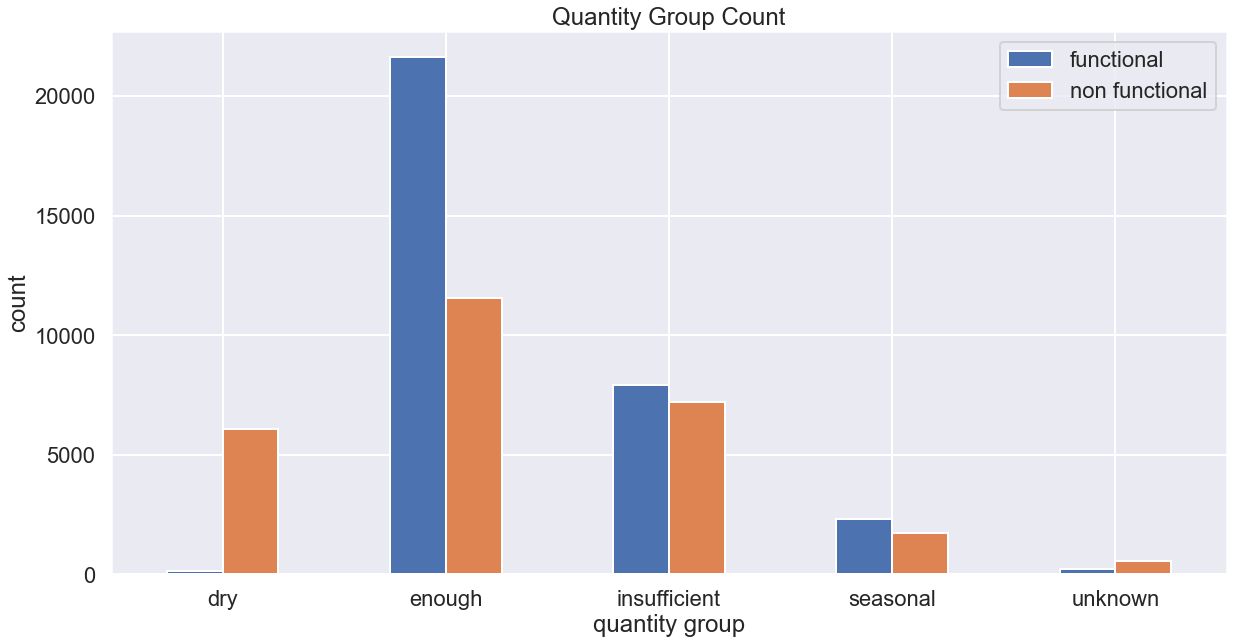

In [74]:
# quantity_group has 0 NaN
fig, ax = plt.subplots(figsize=(20,10))
df.groupby(['quantity_group', 'status_group'])['status_group'].count().unstack().plot(kind = 'bar', ax=ax)
ax.set_title('Quantity Group Count')
ax.set_xlabel('quantity group')
ax.set_ylabel('count')
ax.legend(labels=['functional', 'non functional'])
plt.xticks(rotation=0)
plt.show();

In [75]:
df.groupby(['population', 'status_group'])['status_group'].count().unstack()

status_group,0,1
population,,
0,11274.0,10107.0
1,2911.0,4114.0
2,3.0,1.0
3,3.0,1.0
4,9.0,4.0
...,...,...
9865,NaN,1.0
10000,3.0,NaN
11463,1.0,NaN


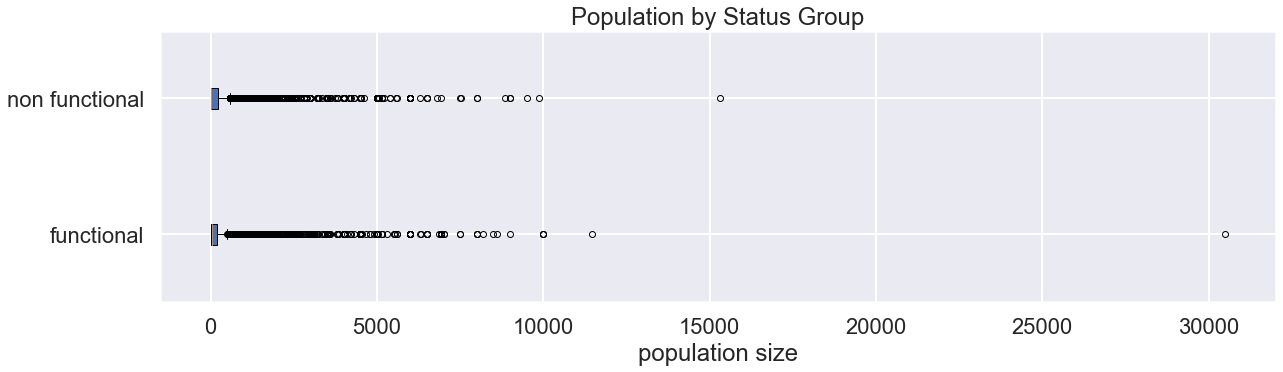

In [76]:
# population has 0 NaN
fig, ax = plt.subplots(figsize = (20, 5))
ax.boxplot([df[df.status_group==0].population, df[df.status_group==1].population],
           labels=['functional','non functional'], vert=False, patch_artist=True)
ax.set_title('Population by Status Group')
ax.set_xlabel('population size');

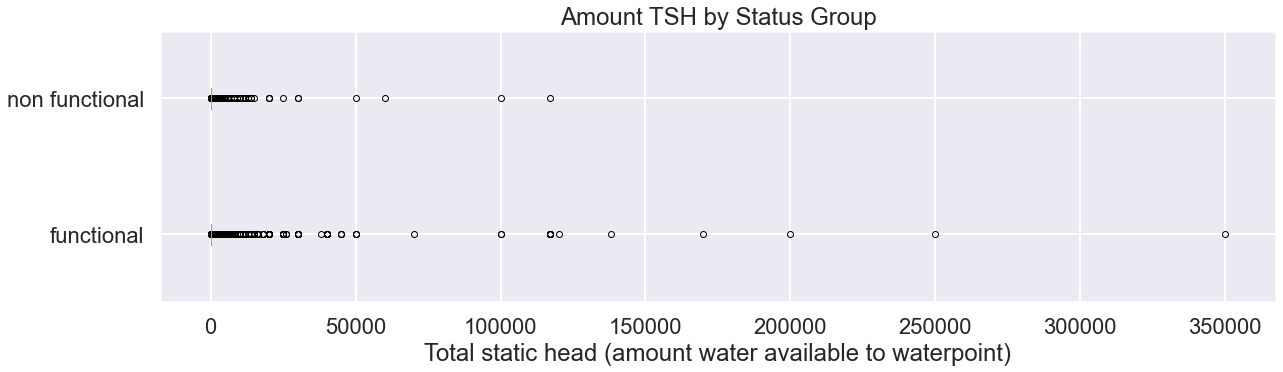

In [77]:
# amount_tsh has 0 NaN
fig, ax = plt.subplots(figsize = (20, 5))
ax.boxplot([df[df.status_group==0].amount_tsh, df[df.status_group==1].amount_tsh],
           labels=['functional','non functional'], vert=False, patch_artist=True)
ax.set_title('Amount TSH by Status Group')
ax.set_xlabel('Total static head (amount water available to waterpoint)');

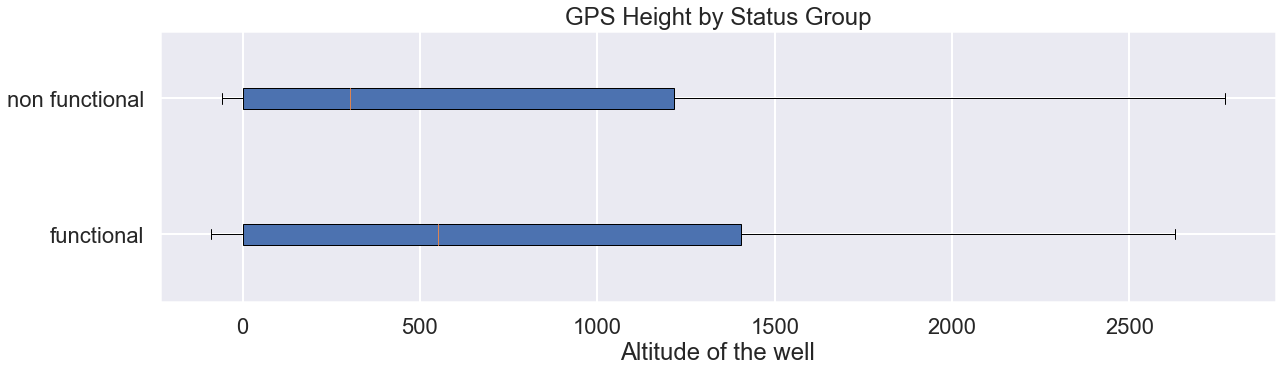

In [78]:
# gps_height has 0 NaN
fig, ax = plt.subplots(figsize = (20, 5))
ax.boxplot([df[df.status_group==0].gps_height, df[df.status_group==1].gps_height],
           labels=['functional','non functional'], vert=False, patch_artist=True)
ax.set_title('GPS Height by Status Group')
ax.set_xlabel('Altitude of the well');

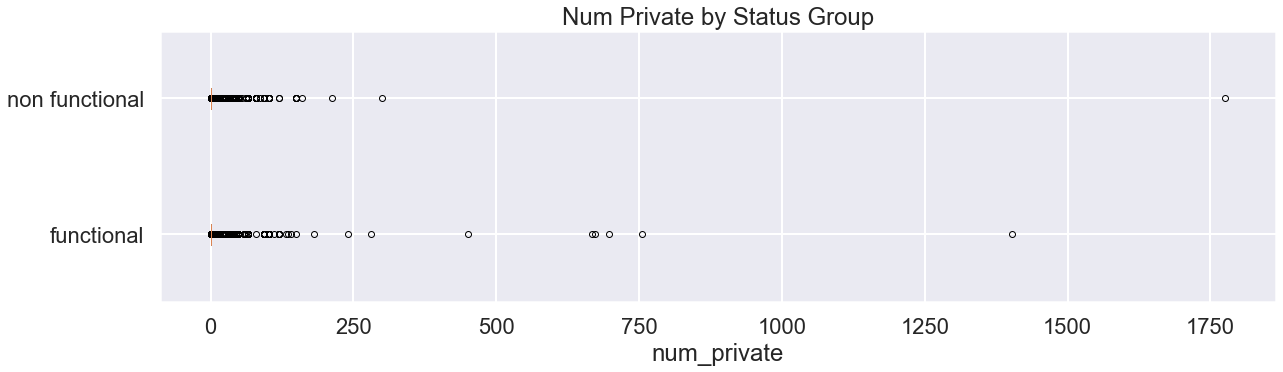

In [79]:
# num_private has 0 NaN
fig, ax = plt.subplots(figsize = (20, 5))
ax.boxplot([df[df.status_group==0].num_private, df[df.status_group==1].num_private],
           labels=['functional','non functional'], vert=False, patch_artist=True)
ax.set_title('Num Private by Status Group')
ax.set_xlabel('num_private');

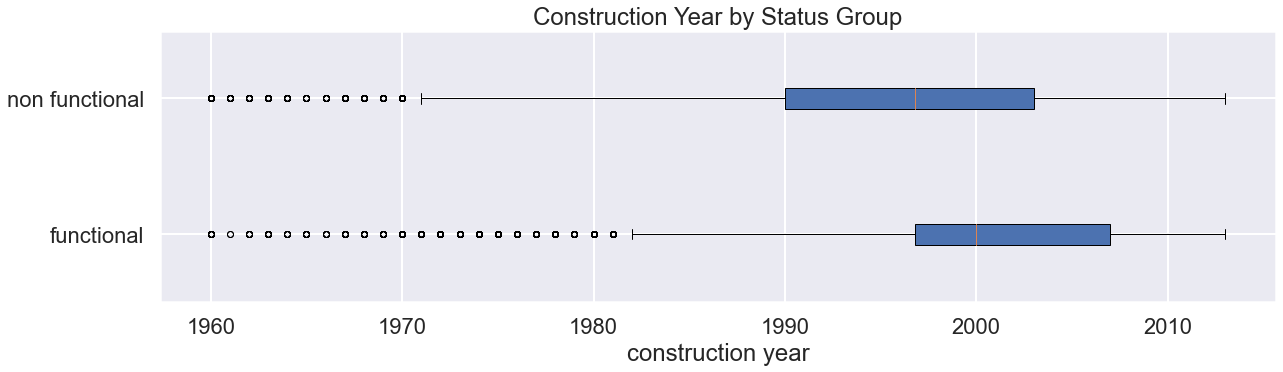

In [80]:
# construction_year has 0 NaN
fig, ax = plt.subplots(figsize = (20, 5))
ax.boxplot([df[df.status_group==0].construction_year, df[df.status_group==1].construction_year],
           labels=['functional','non functional'], vert=False, patch_artist=True)
ax.set_title('Construction Year by Status Group')
ax.set_xlabel('construction year');

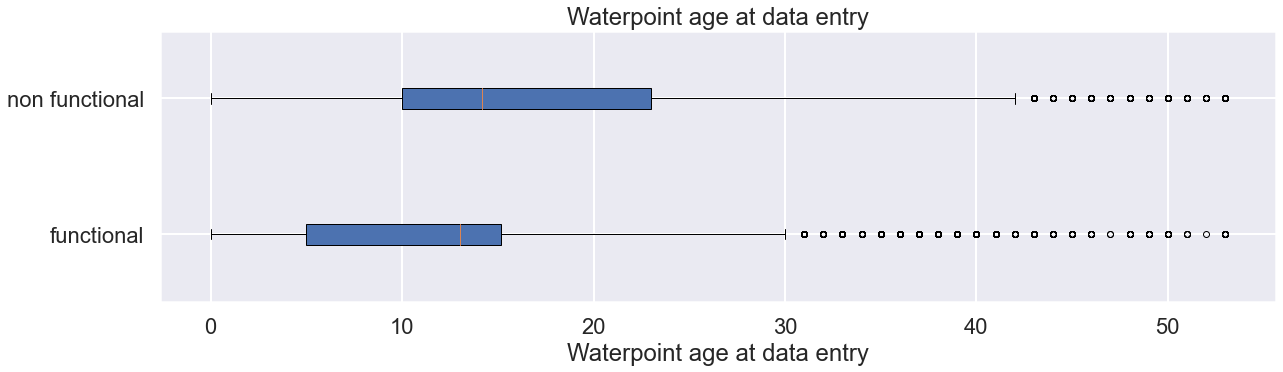

In [81]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.boxplot([df[df.status_group==0].age, df[df.status_group==1].age],
           labels=['functional','non functional'], vert=False, patch_artist=True)
ax.set_title('Waterpoint age at data entry')
ax.set_xlabel('Waterpoint age at data entry');

## Correlation coefficients

<AxesSubplot:>

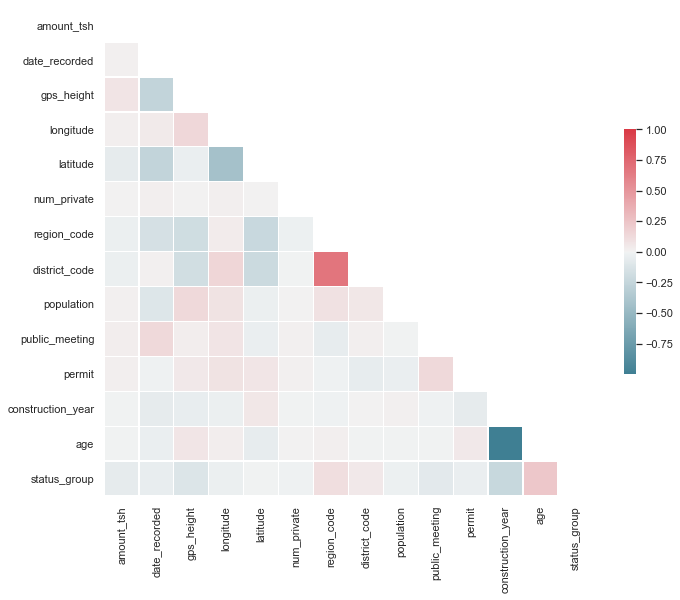

In [82]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [83]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,permit,construction_year,age,status_group
amount_tsh,NaN,0.014629,0.076650,0.022134,0.052670,0.002944,0.026813,0.023599,0.016288,0.025683,0.025042,0.002133,0.002577,0.052427
date_recorded,NaN,NaN,0.255878,0.048938,0.256633,0.020389,0.149176,0.012064,0.099737,0.137278,0.011937,0.054323,0.036113,0.037747
gps_height,NaN,NaN,NaN,0.149155,0.035751,0.007237,0.183521,0.171233,0.135003,0.032375,0.054861,0.039787,0.069574,0.112990
longitude,NaN,NaN,NaN,NaN,0.425802,0.023873,0.034197,0.151398,0.086590,0.078829,0.087063,0.028399,0.029411,0.027332
latitude,NaN,NaN,NaN,NaN,NaN,0.006837,0.221018,0.201020,0.022152,0.034383,0.072301,0.061436,0.046409,0.000411
num_private,NaN,NaN,NaN,NaN,NaN,NaN,0.020377,0.004478,0.003818,0.011230,0.011962,0.004930,0.003635,0.005780
region_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.678602,0.094088,0.044806,0.010835,0.005827,0.021320,0.104178
district_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061831,0.023855,0.047837,0.003963,0.002528,0.056028
population,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000398,0.034684,0.017024,0.004685,0.017674
public_meeting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140349,0.009142,0.001287,0.068406


In [84]:
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

#if you change inplace to True it will go through and drop all of those columns from the dataset
df.drop(columns=to_drop, inplace=False)
df.drop(columns=to_drop, inplace=False)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,9.810959,Roman,1390,other,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0
8776,0.0,7.830137,Grumeti,1399,other,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0
34310,25.0,7.854795,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0
67743,0.0,7.931507,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1
19728,0.0,9.479452,Action In A,0,other,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,7.671233,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0
27263,4700.0,9.663014,Cefa-njombe,1212,other,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,0
37057,0.0,9.734247,NaN,0,other,34.017087,-8.750434,Mashine,0,Rufiji,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,0


In [85]:
to_drop

['age']

##### Note: age is highly correlated with construction_year

## Create dummy variables and drop columns

In [86]:
X_drop = X.drop(columns = ['funder', 
                           'wpt_name', 
                           'subvillage', 
                           'region_code', 
                           'lga',
                           'ward',
                           'recorded_by', 
                           'scheme_name', 
                           'extraction_type_group',
                           'extraction_type_class',
                           'payment', 
                           'quality_group', 
                           'quantity_group', 
                           'source_type', 
                           'source_class', 
                           'scheme_management',
                           'district_code',
                           'waterpoint_type_group',
                          'construction_year'])

In [88]:
# The columns we chose to be made into dummy variables
dummy = ['basin', 
         'region',  
         'management', 
         'management_group',
         'waterpoint_type', 
         'payment_type', 
         'water_quality', 
         'quantity', 
         'source', 
         'extraction_type',
         'installer',
        ]

In [89]:
def to_dummies(df, features):
    """
    Generating dummy variables for feature
    parama: df
            features - list of features
    """
    d_df = []
    for f in features:
        d_df.append(pd.get_dummies(df[f], prefix='{}'.format(str(f)[:3]), drop_first=True))
    df = df.drop(features, axis = 1)
    df = pd.concat([df] + d_df ,axis=1)
    return df

In [90]:
features1 = to_dummies(X_drop, dummy)

In [91]:
features1.shape

(59400, 141)

In [92]:
# created a function to plot a confusion matrix
def plot_confusion_matrix(
    cm,
    classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
):
    '''
    Function that prints and plots a model's confusion matrix.
    Input
    -----
    cm : sklearn confusion matrix
        `sklearn.metrics.confusion_matrix(y_true, y_pred)`

    classes : list (str)
        Names of target classes.
    Optional input
    --------------
    normalize : bool
        Whether to apply normalization (default=False).
        Normalization can be applied by setting `normalize=True`.
    title : str
        Title of the returned plot.
    cmap : matplotlib color map
        For options, visit:
        `https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html`
    Output
    ------
    Prints a stylized confusion matrix.
    '''
    # convert to percentage, if normalize set to True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # format true positives and others
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=16,
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # add axes labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [99]:
sns.set(style="white")
sns.set_context('poster')

## Modeling

### Logistic Regression

In [172]:
# we are splitting our training and testing data - 80% of our data will be in the training set, 20% will be in our test set
X_train, X_test, y_train, y_test = train_test_split(features1, y, test_size = 0.2, random_state = 1) 

In [173]:
# setting logreg equal to our logistic regression function
logreg =LogisticRegression()
# fitting our data onto our model
logreg.fit(X_train, y_train)
# using our model to predict our y values with our test set data
y_pred_class = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
# predict probabilities for our testing target variable using our model
logreg.predict_proba(X_test)

/Users/dariga_kokenova/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/dariga_kokenova/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[0.53511432, 0.46488568],
       [0.65308284, 0.34691716],
       [0.56104544, 0.43895456],
       ...,
       [0.50521014, 0.49478986],
       [0.55110966, 0.44889034],
       [0.694646  , 0.305354  ]])

In [175]:
# creating a dictionary to show our coefficents for each independent variable
dictionary=dict(zip(list(X_train.columns), list(logreg.coef_[0])))
dictionary

{'amount_tsh': -0.0001890993215840266,
 'date_recorded': -0.19801109011966123,
 'gps_height': -0.0003493795585521791,
 'longitude': 0.028517107554962673,
 'latitude': -0.06620639329986609,
 'num_private': -0.025906290281008104,
 'population': -0.00011866095100193254,
 'public_meeting': -0.048902000976666665,
 'permit': -0.034136548334711615,
 'age': 0.05421287221771244,
 'bas_Lake Nyasa': -0.03209442070670612,
 'bas_Lake Rukwa': 0.01895175641875229,
 'bas_Lake Tanganyika': 0.020707959656629735,
 'bas_Lake Victoria': -0.004646298556428203,
 'bas_Pangani': -0.028882362948244436,
 'bas_Rufiji': -0.0306459538952121,
 'bas_Ruvuma / Southern Coast': 0.03972956905097517,
 'bas_Wami / Ruvu': 0.007713391111883662,
 'reg_Dar es Salaam': -0.0031290979795058327,
 'reg_Dodoma': 0.0044405593710276775,
 'reg_Iringa': -0.04488583786134109,
 'reg_Kagera': -0.010757163291619527,
 'reg_Kigoma': 0.018794290152457465,
 'reg_Kilimanjaro': -0.010230132794586622,
 'reg_Lindi': 0.019701038962928737,
 'reg_Many

In [176]:
# checking accuracy
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, y_pred_train))
# checking precision
print('Test Precision score: ', metrics.precision_score(y_test, y_pred_class))
print('Train Precision score: ', metrics.precision_score(y_train, y_pred_train))
# checking Recall (Sensitivity)
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, y_pred_class))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, y_pred_train))
# checking F1 score
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))
print('Train F1 score: ', metrics.f1_score(y_train, y_pred_train))

Test Accuracy score:  0.6622053872053872
Train Accuracy score:  0.6670875420875421
Test Precision score:  0.6632443531827515
Train Precision score:  0.6690055788807729
Test Recall (Sensitivity) score:  0.533982365907421
Train Recall (Sensitivity) score:  0.5361109830852192
Test F1 score:  0.5916352905261015
Train F1 score:  0.5952307849759493


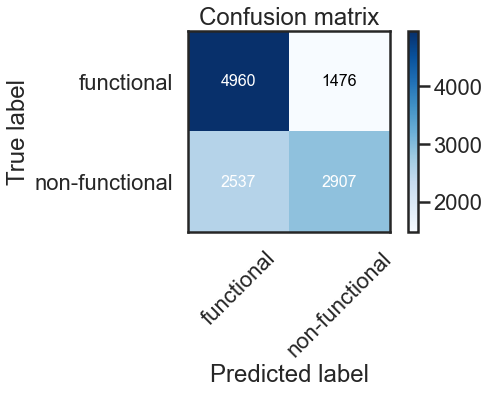

In [177]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred_class)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

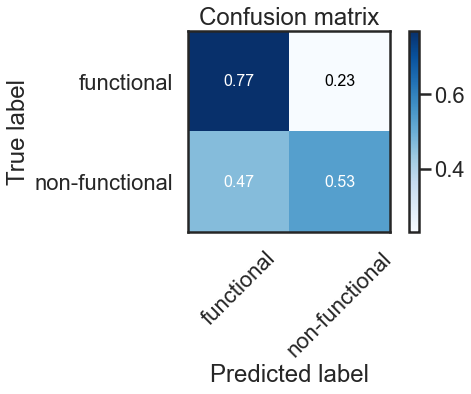

In [178]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred_class)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

##### This is our first simple model. This is already better than our baseline, which is great to work off of!. Our baseline was 54.4% while our Accuracy score here is 12% higher at 66.2%

In [101]:
THRESHOLD = 0.5
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"], columns=['value'])

,value
accuracy,0.662205
recall,0.533982
precision,0.663244
F1,0.591635


In [102]:
THRESHOLD = 0.3
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"], columns=['value'])

,value
accuracy,0.571633
recall,0.890889
precision,0.518994
F1,0.655893


In [103]:
THRESHOLD = 0.4
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"], columns=['value'])

,value
accuracy,0.634680
recall,0.751286
precision,0.578010
F1,0.653355


In [104]:
THRESHOLD = 0.8
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"], columns=['value'])

,value
accuracy,0.572643
recall,0.081007
precision,0.856311
F1,0.148011


# AUC

In [105]:
y_pred_proba = logreg.predict_proba(X_test)

In [106]:
y_test.value_counts()

status_group
0               6436
1               5444
dtype: int64

In [107]:
y_test.shape

(11880, 1)

In [108]:
y_pred_proba.shape

(11880, 2)

In [109]:
y_pred_proba

array([[0.53511432, 0.46488568],
       [0.65308284, 0.34691716],
       [0.56104544, 0.43895456],
       ...,
       [0.50521014, 0.49478986],
       [0.55110966, 0.44889034],
       [0.694646  , 0.305354  ]])

In [110]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred_prob

array([0.46488568, 0.34691716, 0.43895456, ..., 0.49478986, 0.44889034,
       0.305354  ])

(array([0.        , 0.        , 0.        , ..., 0.99922312, 0.99922312,
        1.        ]),
 array([0.00000000e+00, 1.83688464e-04, 4.04114622e-03, ...,
        9.99816312e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.95574666e+00, 9.55746661e-01, 9.27623567e-01, ...,
        5.38976174e-04, 4.70842490e-04, 1.33229457e-10]))

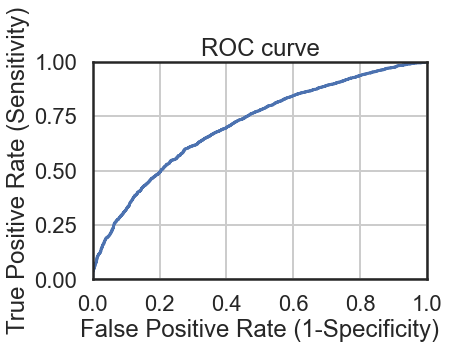

In [111]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

fpr, tpr, thresholds

In [112]:
def evaluate_threshold(threshold):
    print('Sensitivity: ' , tpr[thresholds>threshold][-1])
    print('Specificity: ' , 1-fpr[thresholds>threshold][-1])

In [113]:
evaluate_threshold(.3)
print(metrics.roc_auc_score(y_test, y_pred_prob))

Sensitivity:  0.8908890521675239
Specificity:  0.30158483530142943
0.7117590071278888


In [114]:
evaluate_threshold(.4)
print(metrics.roc_auc_score(y_test, y_pred_prob))

Sensitivity:  0.7511021307861866
Specificity:  0.5360472343070231
0.7117590071278888


In [115]:
evaluate_threshold(.5)
print(metrics.roc_auc_score(y_test, y_pred_prob))

Sensitivity:  0.533982365907421
Specificity:  0.7708203853325046
0.7117590071278888


In [116]:
evaluate_threshold(.8)
print(metrics.roc_auc_score(y_test, y_pred_prob))

Sensitivity:  0.08100661278471712
Specificity:  0.9885021752641392
0.7117590071278888


### KNN Classifier

In [122]:
# scaled X_train and X_test to make variables similary scaled and centered
scaler = StandardScaler()
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [123]:
# creating our KNN classifier and setting it equal to knn with n_neighbors equals 1. We wanted this to be as precise as possible
# so we wanted it based on one neighbor
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
# fitting our training data into our knn model
knn.fit(X_train, y_train)
# predicting our dependet variable using our model and test data
knn_preds = knn.predict(X_test)
knn_preds_train = knn.predict(X_train)

<ipython-input-123-a3ec24ae5bff>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)


In [124]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, knn_preds))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, knn_preds_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, knn_preds))
print('Train Precision score: ', metrics.precision_score(y_train, knn_preds_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test,knn_preds))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, knn_preds_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, knn_preds))
print('Train F1 score: ', metrics.f1_score(y_train, knn_preds_train))

Test Accuracy score:  0.7872053872053872
Train Accuracy score:  0.9979587542087542
Test Precision score:  0.7758229284903518
Train Precision score:  0.9977876106194691
Test Recall (Sensitivity) score:  0.7533063923585599
Train Recall (Sensitivity) score:  0.9977416232658893
Test F1 score:  0.764398881640261
Train F1 score:  0.9977646164127855


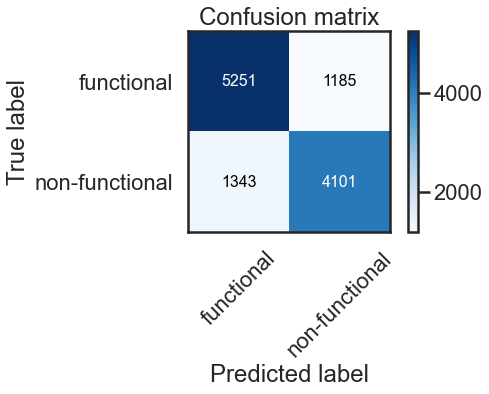

In [125]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, knn_preds)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

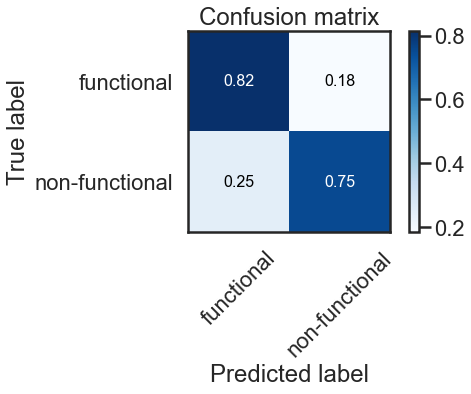

In [126]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, knn_preds)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

### Searching for optimal hyperparameter K

In [127]:
# search for an optimal value of K for KNN
k_range = list(range(1, 11))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    score = metrics.recall_score(y_test, y_predict) # can replace accuracy with precision, recall
    k_scores.append( score)
print(k_scores)

<ipython-input-127-0d14fc55992f>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)
<ipython-input-127-0d14fc55992f>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)
<ipython-input-127-0d14fc55992f>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)
<ipython-input-127-0d14fc55992f>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)
<ipython-input-127-0d14fc55992f>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[0.7533063923585599, 0.6250918442321822, 0.742836149889787, 0.6655033063923586, 0.7325495958853784, 0.6688096987509184, 0.7237325495958854, 0.6746877296105804, 0.7204261572373255, 0.6713813372520205]


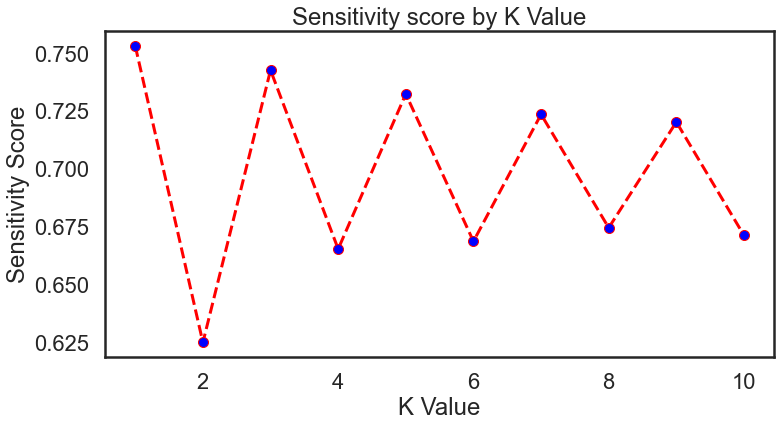

In [128]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 11), k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Sensitivity score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Sensitivity Score') 
plt.show()

In [129]:
# search for an optimal value of K for KNN
k_range = list(range(1, 61, 5))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    score = metrics.recall_score(y_test, y_predict) # can replace accuracy with precision, recall
    k_scores.append( score)
print(k_scores)

<ipython-input-129-7268af999404>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)
<ipython-input-129-7268af999404>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)
<ipython-input-129-7268af999404>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)
<ipython-input-129-7268af999404>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)
<ipython-input-129-7268af999404>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[0.7533063923585599, 0.6688096987509184, 0.7051800146950772, 0.6642174871418075, 0.6818515797207936, 0.6517266715650257, 0.6638501102130786, 0.6403379867744305, 0.6504408523144747, 0.6300514327700221, 0.6401542983100661, 0.6210506980161646]


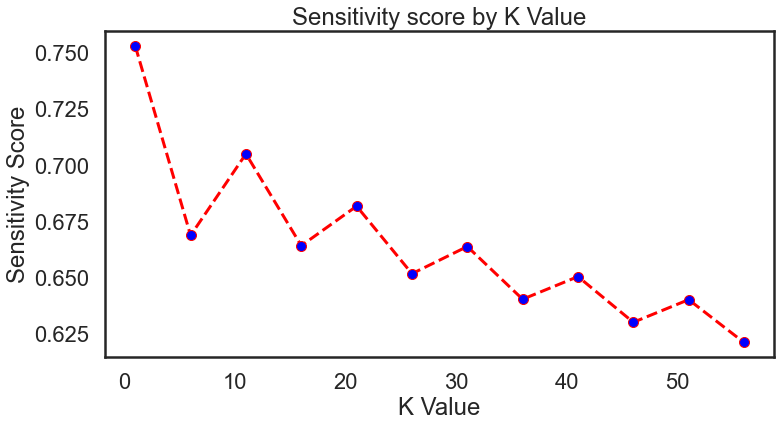

In [130]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 61, 5), k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Sensitivity score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Sensitivity Score') 
plt.show()

#### KNN using a different hyperparameter

In [140]:
# rerunning our train test split at we had scaled it in KNN previously
X_train, X_test, y_train, y_test = train_test_split(features1, y, test_size = 0.2, random_state = 1)
# scaled X_train and X_test to make variables similary scaled and centered
scaler = StandardScaler()
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [141]:
# creating our KNN classifier and setting it equal to knn with n_neighbors equals 1. We wanted this to be as precise as possible
# so we wanted it based on one neighbor
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
# fitting our training data into our knn model
knn.fit(X_train, y_train)
# predicting our dependet variable using our model and test data
knn_preds = knn.predict(X_test)
knn_preds_train = knn.predict(X_train)

<ipython-input-141-2cb61fe1ec1e>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)


In [142]:
cm = confusion_matrix(y_test, knn_preds)
cm

array([[5402, 1034],
       [1456, 3988]])

In [143]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, knn_preds))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, knn_preds_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, knn_preds))
print('Train Precision score: ', metrics.precision_score(y_train, knn_preds_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test,knn_preds))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, knn_preds_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, knn_preds))
print('Train F1 score: ', metrics.f1_score(y_train, knn_preds_train))

Test Accuracy score:  0.7904040404040404
Train Accuracy score:  0.8511153198653199
Test Precision score:  0.7941059338908801
Train Precision score:  0.8588396976538726
Test Recall (Sensitivity) score:  0.7325495958853784
Train Recall (Sensitivity) score:  0.8064709406830437
Test F1 score:  0.7620867571182878
Train F1 score:  0.8318319032112381


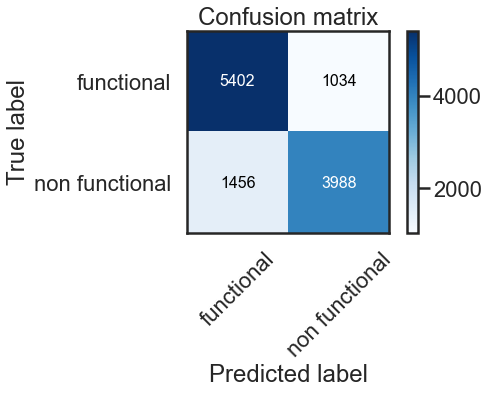

In [144]:
plot_confusion_matrix(
    cm,
    ['functional', 'non functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

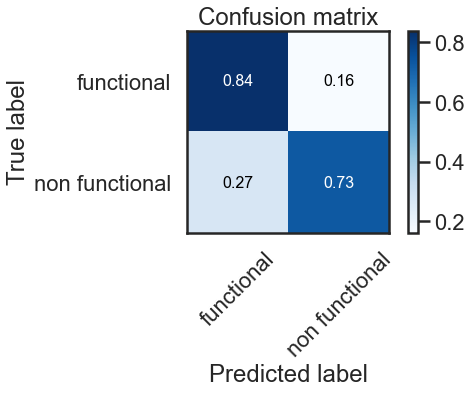

In [145]:
plot_confusion_matrix(
    cm,
    ['functional', 'non functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

##### Increasing hyperparameter K decreases the sensitivity metric. Our optimal hyperparameter is K = 1 as we are trying to maximize our sensitivity score. There is a high risk of overfitting with K=1.  To show how much this model is overfitting, we have shown you are accuracy score from both our test data and our train data. The model fits our train data almost perfectly while our test data has a 78% accuracy score. 

### Decision Tree

In [150]:
# rerunning our train test split at we had scaled it in KNN previously
X_train, X_test, y_train, y_test = train_test_split(features1, y, test_size = 0.2, random_state = 1) 
# training a DescisionTreeClassifier with unspecified max depth
dtree_model = DecisionTreeClassifier().fit(X_train, y_train) 
# calculating our predictions for our model using our test data
dtree_predictions = dtree_model.predict(X_test) 
dtree_predictions_train = dtree_model.predict(X_train)

In [151]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, dtree_predictions))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, dtree_predictions_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, dtree_predictions))
print('Train Precision score: ', metrics.precision_score(y_train, dtree_predictions_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, dtree_predictions))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, dtree_predictions_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, dtree_predictions))
print('Train F1 score: ', metrics.f1_score(y_train, dtree_predictions_train))

Test Accuracy score:  0.7828282828282829
Train Accuracy score:  0.9983585858585858
Test Precision score:  0.7659732540861813
Train Precision score:  0.999307127349993
Test Recall (Sensitivity) score:  0.7575312270389419
Train Recall (Sensitivity) score:  0.9970963727704291
Test F1 score:  0.7617288511267085
Train F1 score:  0.9982005260000922


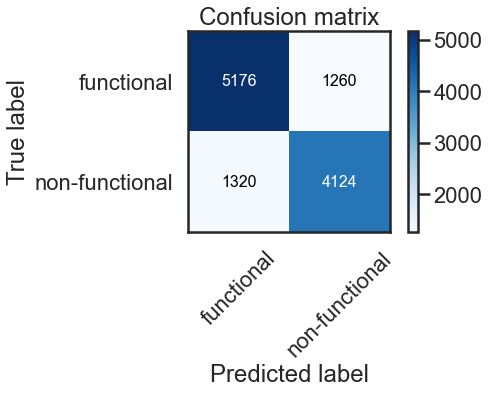

In [152]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, dtree_predictions)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

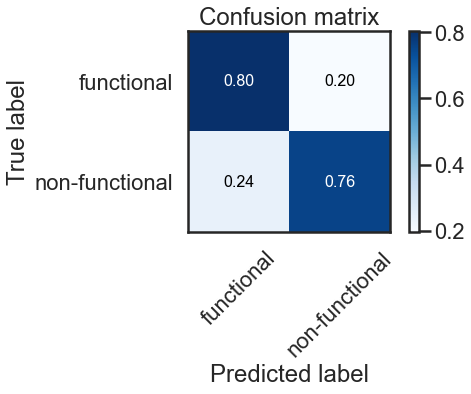

In [153]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, dtree_predictions)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

### Using GridSearchCV

In [124]:
dt_param_grid = {
    'criterion': ['gini'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
}

# instantiate GridSearchCV. Specifying that we are looking to return our highest recall score.
dt_grid_search = GridSearchCV(dtree_model, dt_param_grid, cv=5, scoring='recall', return_train_score=True, verbose = 1, n_jobs=-1)
# fit to the data
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.3min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=17), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45,
                                       50]},
             return_train_score=True, scoring='recall', verbose=1)

In [125]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)
print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 88.61%
Mean Test Score: 75.29%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini', 'max_depth': 30}

### Decision tree using a different max_depth

In [146]:
# rerunning our train test split at we had scaled it in KNN previously
X_train, X_test, y_train, y_test = train_test_split(features1, y, test_size = 0.2, random_state = 1) 
# training a DescisionTreeClassifier with unspecified max depth
dtree_model = DecisionTreeClassifier(max_depth = 30).fit(X_train, y_train) 
# calculating our predictions for our model using our test data
dtree_predictions = dtree_model.predict(X_test) 
dtree_predictions_train = dtree_model.predict(X_train)

In [147]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, dtree_predictions))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, dtree_predictions_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, dtree_predictions))
print('Train Precision score: ', metrics.precision_score(y_train, dtree_predictions_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, dtree_predictions))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, dtree_predictions_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, dtree_predictions))
print('Train F1 score: ', metrics.f1_score(y_train, dtree_predictions_train))

Test Accuracy score:  0.787962962962963
Train Accuracy score:  0.9894149831649832
Test Precision score:  0.7756833176248822
Train Precision score:  0.9954184198223469
Test Recall (Sensitivity) score:  0.755878030859662
Train Recall (Sensitivity) score:  0.9813338249527584
Test F1 score:  0.7656526188482649
Train F1 score:  0.988325945180681


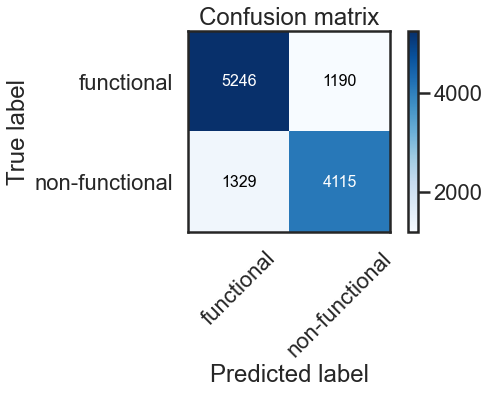

In [148]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, dtree_predictions)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

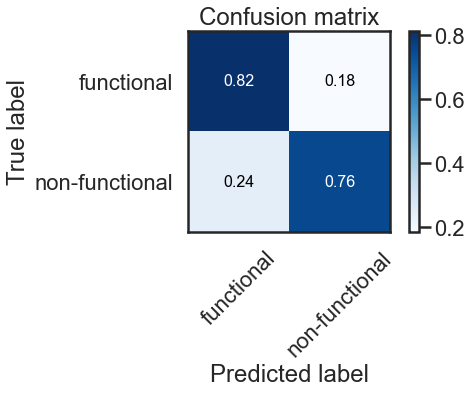

In [149]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, dtree_predictions)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

#### We ran our first model using max_depth None to see how it would fair. That model was highly overfitted. We then used grid search to see if we could find a max depth that may be more optimal and less over fitting. Recommended max_depth 30 also overfits. We will evaluate other models to compare to decision tree results.

### Random Forests

In [160]:
# create a Random Forest Classifier, with our random state equaling 42
clf=RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 2, random_state = 42, n_jobs=-1)
# train the model using the training sets y_pred=clf.predict(X_test)
jungle_model = clf.fit(X_train,y_train)
# predicitng our dependent variable using our model and the test data for our independent variable
y_pred=jungle_model.predict(X_test)
y_pred_train=jungle_model.predict(X_train)

<ipython-input-160-1927bf1da085>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  jungle_model = clf.fit(X_train,y_train)


In [161]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, y_pred_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, y_pred))
print('Train Precision score: ', metrics.precision_score(y_train, y_pred_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, y_pred))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, y_pred_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, y_pred))
print('Train F1 score: ', metrics.f1_score(y_train, y_pred_train))

Test Accuracy score:  0.8232323232323232
Train Accuracy score:  0.9983375420875421
Test Precision score:  0.8279717536288741
Train Precision score:  0.9988462248477017
Test Recall (Sensitivity) score:  0.7753490080822925
Train Recall (Sensitivity) score:  0.9975111766603678
Test F1 score:  0.800796812749004
Train F1 score:  0.9981782543525884


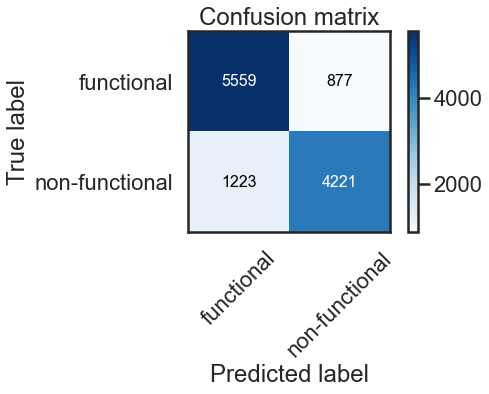

In [162]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

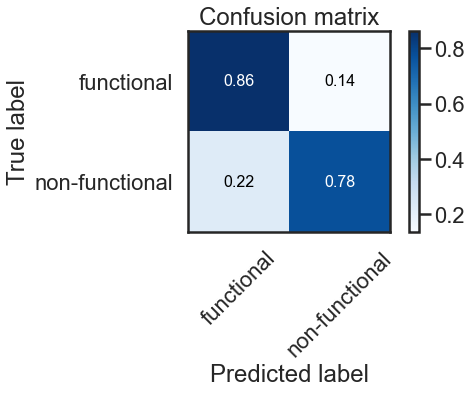

In [163]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

### Random forest using a different max_depth

In [164]:
# create a Random Forest Classifier, with our random state equaling 42
clf=RandomForestClassifier(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, random_state = 42, n_jobs=-1)
# train the model using the training sets y_pred=clf.predict(X_test)
jungle_model = clf.fit(X_train,y_train)
# predicitng our dependent variable using our model and the test data for our independent variable
y_pred=jungle_model.predict(X_test)
y_pred_train=jungle_model.predict(X_train)

<ipython-input-164-0ff328ea95f2>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  jungle_model = clf.fit(X_train,y_train)


In [165]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, y_pred_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, y_pred))
print('Train Precision score: ', metrics.precision_score(y_train, y_pred_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, y_pred))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, y_pred_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, y_pred))
print('Train F1 score: ', metrics.f1_score(y_train, y_pred_train))

Test Accuracy score:  0.8235690235690236
Train Accuracy score:  0.9309132996632996
Test Precision score:  0.8531645569620253
Train Precision score:  0.9709944751381215
Test Recall (Sensitivity) score:  0.742836149889787
Train Recall (Sensitivity) score:  0.8748214038807208
Test F1 score:  0.7941869599371563
Train F1 score:  0.9204024730270336


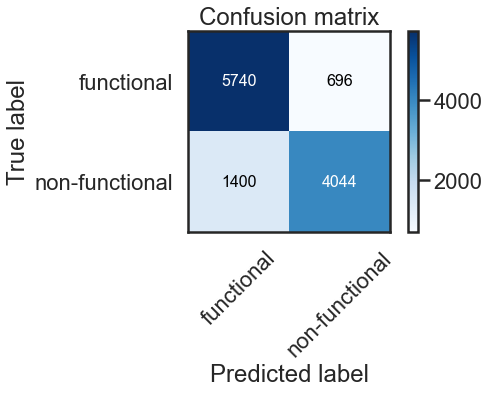

In [166]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

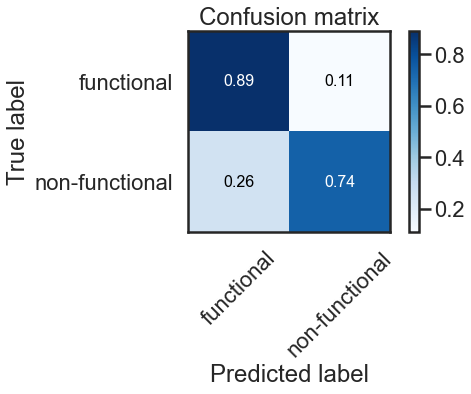

In [167]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

### Random forest using a different max_depth

In [168]:
# create a Random Forest Classifier, with our random state equaling 42
clf=RandomForestClassifier(max_depth = 35, min_samples_leaf = 1, min_samples_split = 2, random_state = 42, n_jobs=-1)
# train the model using the training sets y_pred=clf.predict(X_test)
jungle_model = clf.fit(X_train,y_train)
# predicitng our dependent variable using our model and the test data for our independent variable
y_pred=jungle_model.predict(X_test)
y_pred_train=jungle_model.predict(X_train)

<ipython-input-168-2a81f7505081>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  jungle_model = clf.fit(X_train,y_train)


In [169]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, y_pred_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, y_pred))
print('Train Precision score: ', metrics.precision_score(y_train, y_pred_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, y_pred))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, y_pred_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, y_pred))
print('Train F1 score: ', metrics.f1_score(y_train, y_pred_train))

Test Accuracy score:  0.8263468013468014
Train Accuracy score:  0.9979377104377104
Test Precision score:  0.8317958783120707
Train Precision score:  0.9987069960748095
Test Recall (Sensitivity) score:  0.7784717119764879
Train Recall (Sensitivity) score:  0.996773747522699
Test F1 score:  0.8042508776923807
Train F1 score:  0.9977394353201697


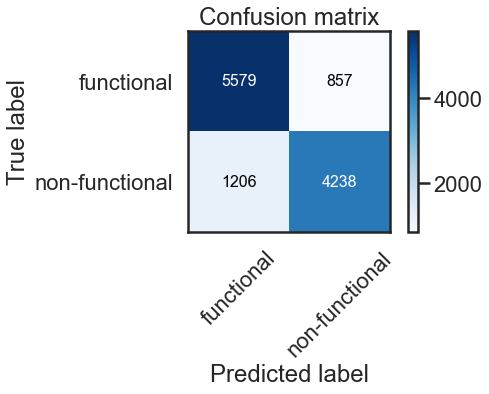

In [170]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

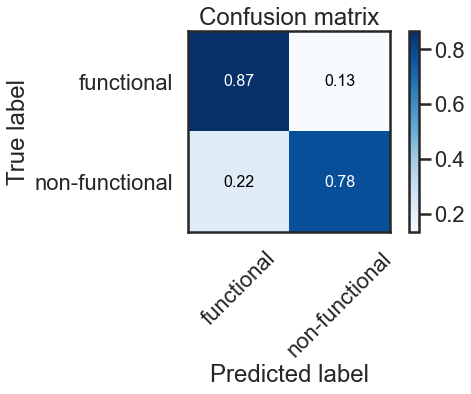

In [171]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

### Using GridSearchCV

In [157]:
# create our parameters for grid search function
dt_param_grid = {
    'criterion': ['gini'],
    'max_depth': [None, 20, 22, 24, 25, 26, 27, 35],
}
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(jungle_model, dt_param_grid, cv=5, scoring='recall', return_train_score=True, verbose = 1, n_jobs=-1)
# Fit to the data
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.0min finished
/Users/christadawson/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=35, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [None, 20, 22, 24, 25, 26, 27, 35]},
             return_train_score=True, scoring='recall', verbose=1)

In [158]:
# mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
# mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)
# printing each score out
print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
# printing our what our best parameters were given our criteria
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 95.70%
Mean Test Score: 77.85%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini', 'max_depth': 35}

##### Random Forest gives us the highest accuracy score for any of our models. We ran our first model running our max_depth at None to see how it would fair. We realized quickly that this model would be very overfitting. We then used grid search to see if we could find a max depth that may be more optimal and less over fitting. We made our criteria based on maximizing our recall score as that was our most important metric. Grid search came back with a max_level of 35, which was great for our sensitivity score but was still very overfitting. We decided to do some trial and error to see if we could make our model less overfitting without downgrading our recall score too much. Through doing this, we found that a max_depth of 20 grave us the best tradeoff between a high recall score and less overfitting! Althought Random Forest still overfits our model (as you can see in our accuracy score in training vs testing data) it is less overfit than our decision tree/knn model, is very accurate, and gives us the highest recall score out of the previous three models.

### AdaBoosting

In [159]:
# create adaboost classifier model
adaboost_clf = AdaBoostClassifier()
# fit our model to training data set
adaboost_model = adaboost_clf.fit(X_train, y_train)

/Users/christadawson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [160]:
# predict our dependent variable for our test set
adaboost_test_preds = adaboost_clf.predict(X_test)
# predict our depedent variable for our train set
adaboost_train_preds = adaboost_clf.predict(X_train)

In [161]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, adaboost_test_preds))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, adaboost_train_preds))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, adaboost_test_preds))
print('Train Precision score: ', metrics.precision_score(y_train, adaboost_train_preds))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, adaboost_test_preds))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, adaboost_train_preds))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, adaboost_test_preds))
print('Train F1 score: ', metrics.f1_score(y_train, adaboost_train_preds))

Test Accuracy score:  0.7452020202020202
Train Accuracy score:  0.7460858585858586
Test Precision score:  0.7786488356006456
Train Precision score:  0.7749671672471878
Test Recall (Sensitivity) score:  0.6203159441587068
Train Recall (Sensitivity) score:  0.6255242660275614
Test F1 score:  0.6905224414681524
Train F1 score:  0.6922723794950268


##### Our Adaboost model increased our accuracy from our baseline model and did not over fit on the test data. However, our recall score was much lower than previous models (Decision Tree and Random Forest), which was the most important metric to consider as we did not want to predict something to be functional when it is in fact non-functional/in need of repair.


## Gradient Boosting

In [167]:
# creating gradient boost classifier and setting it equal to gbt_clf
gbt_clf = GradientBoostingClassifier()
# fitting our model using training data
gbt_model = gbt_clf.fit(X_train, y_train)

/Users/christadawson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [168]:
# using our model to predict our testing data
gbt_clf_test_preds = gbt_clf.predict(X_test)
# using our model to predict our training data
gbt_clf_train_preds = gbt_clf.predict(X_train)

In [169]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, gbt_clf_test_preds))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, gbt_clf_train_preds))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, gbt_clf_test_preds))
print('Train Precision score: ', metrics.precision_score(y_train, gbt_clf_train_preds))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, gbt_clf_test_preds))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, gbt_clf_train_preds))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, gbt_clf_test_preds))
print('Train F1 score: ', metrics.f1_score(y_train, gbt_clf_train_preds))

Test Accuracy score:  0.7627946127946128
Train Accuracy score:  0.7684764309764309
Test Precision score:  0.8148681055155875
Train Precision score:  0.8180952947474868
Test Recall (Sensitivity) score:  0.6241734019103601
Train Recall (Sensitivity) score:  0.6338664331474397
Test F1 score:  0.7068857915539838
Train F1 score:  0.7142931338942559


##### Again, our Gradient Boosting model increased our accuracy from our baseline model and did not over fit on the test data. However, our recall score was much lower than previous models (Decision Tree and Random Forest), which was the most important metric to consider as we did not want to predict something to be functional when it is in fact non-functional/in need of repair. Overall, it did better than our adaboost model but was not the best overall model.